<a href="https://colab.research.google.com/github/mBohunickaCharles/FIFA_playground/blob/main/fifa_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CASE STUDY: FIFA 2022 PLAYERs**


The dataset used in this project is publicly available and contains selected features of FIFA 2022 football players.

## **ABOUT THE TASK**

Please see bellow the case study tasks summary:

- Perform exploratory data analysis and present the three most interesting insights you discover in the data. You may illustrate these insights using plots and/or summary tables.
- Choose features that can be most informative, when trying to estimate player's value ("value_eur" column) and explain why.
- Prepare an executive summary for a senior manager with no background in data science. The summary should include 2–4 bullet points explaining which features are most important for estimating a player's value. </br></br>

**Summary:** We will focus on the player's market value (EUR), as this is the key area of interest for the executive summary. From a machine learning perspective, this represents a regression task.


## **SETTING UP**

##### MOUNT DRIVE

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### IMPORT LIBRARIES

In [ ]:
# Importing numpy, pandas, matplotlib and seaborn:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# To keep graphs within the nobebook:
%matplotlib inline

# Imports for plotly:
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Display floats to 2dp:
pd.set_option('display.float_format', '{:.2f}'.format)

# Imports for ml:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error

# Import SHAP:
import shap

##### READ CSV FILES

In [ ]:
# Read csv file and assign to players:
players = pd.read_csv('/content/drive/MyDrive/fifa_2022_playground/data_folder/df_players.csv', sep=';', index_col=0)


## **EXPLORATORY DATA ANALYSIS**

In this section, we will explore the data itself and perform some basic data cleaning, where required.

In [ ]:
# Print number of rows, columns:
print(
    f"The players dataset contains {players.shape[0]} samples and "
    f"{players.shape[1]} columns."
)

The players dataset contains 5969 samples and 20 columns.


In [ ]:
# Display first 5 rows of dataset:
players.head()

,sofifa_id,short_name,overall,potential,age,height_cm,weight_kg,club_name,league_name,club_contract_valid_until,preferred_foot,pace,shooting,passing,dribbling,defending,physic,formation,player_tags,value_eur
1,255438,R. Araki,67,80,19,170,60,Kashima Antlers,Japanese J. League Division 1,2022,Right,83.00,61.00,61.00,72.00,22.00,43.00,mid,NaN,2400000
2,246070,Iván Jaime,70,82,20,180,73,Futebol Clube de Famalicão,Portuguese Liga ZON SAGRES,2025,Right,72.00,70.00,65.00,71.00,50.00,60.00,mid,NaN,3800000
3,203173,Noguera,68,68,31,177,65,FC Goa,Indian Super League,2022,Right,75.00,62.00,67.00,69.00,57.00,59.00,mid,NaN,1e+06
4,178090,D. Biseswar,75,75,33,176,79,PAOK,Greek Super League,2022,Right,71.00,69.00,76.00,78.00,33.00,60.00,mid,NaN,3500000
5,223978,Manu García,73,82,23,169,66,Deportivo Alavés,Spain Primera Division,2022,Right,78.00,69.00,72.00,75.00,40.00,56.00,mid,NaN,7e+06


**Observation:**

There are mixed format values in our target column (value_eur).


In [ ]:
# Show the names of all columns in the dataset:
list(players.columns)

['sofifa_id',
 'short_name',
 'overall',
 'potential',
 'age',
 'height_cm',
 'weight_kg',
 'club_name',
 'league_name',
 'club_contract_valid_until',
 'preferred_foot',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'formation',
 'player_tags',
 'value_eur']

In [ ]:
# Create a dataframe with metadata:

data = []

# Defining data category based on data available:
for feature in players.columns:
    if feature == 'sofifa_id':
        category = 'id'
    elif feature in ['short_name', 'age']:
        category = 'personal_data'
    elif feature in ['height_cm','weight_kg']:
        category = 'physical_data'
    elif feature in ['club_name', 'league_name']:
        category = 'affiliation'
    elif feature in ['overall', 'potential']:
        category = 'skills'
    elif feature in ['pace', 'shooting', 'passing', 'dribbling','defending', 'physic']:
        category = 'performance'
    elif feature == 'value_eur':
        category = 'target'
    else:
        category = 'other'

    # Defining the data type
    dtype = players[feature].dtype

    # Defining missing data & % of missing data:
    missing = players[feature].isnull().sum()
    missing_pecentage = players[feature].isnull().sum()/len(players)*100

    # Defining number of unique values per feature:
    uniques = players[feature].nunique()

    # Creating a dictionary that contains all the metadata for the variable:
    feature_dict = { 'varname': feature
                   , 'dtype': dtype
                   , 'category': category
                   , 'missing': missing
                   , '%_missing': missing_pecentage
                   , 'uniques': uniques
         }
    data.append(feature_dict)

meta_data = pd.DataFrame(data, columns=['varname', 'dtype', 'category', 'missing', '%_missing', 'uniques'])
meta_data.set_index('varname', inplace=True)

In [ ]:
# Let's explore meta data for players dataset:
meta_data

,dtype,category,missing,%_missing,uniques
varname,,,,,
sofifa_id,int64,id,0,0.00,5969
short_name,object,personal_data,0,0.00,5786
overall,int64,skills,0,0.00,46
potential,int64,skills,0,0.00,42
age,int64,personal_data,0,0.00,27
height_cm,int64,physical_data,0,0.00,46
weight_kg,int64,physical_data,0,0.00,49
club_name,object,affiliation,0,0.00,543
league_name,object,affiliation,0,0.00,46


**Observations:**

 - Target column value_eur has a dtype of object, this should be a numerical value.

 - Each player has a unique sofifa_id, and the total number of samples matches the number of unique IDs.

 - Player names (short_name column) contain duplicate values. We will investigate this further to confirm there are no duplicate data entries.

 - The performance category has approximately 9% missing values. We will have a closer look at those.

 - The player_tags column has over 88% missing values. We will drop the column, as the % of missing is too high.



### **TARGET COLUMN (value_eur)**

FIX TARGET COLUMN DATA TYPE

Here, we will fix the dtype of target column from object to integer.

In [ ]:
# Fix format of strings '4,5e+07' to '4.5e+07' so it's convertable:
players['value_eur'] = players['value_eur'].str.replace(',', '.')
# Convert column dtype to float:
players['value_eur'] = players['value_eur'].astype(float).astype(int)

DISPLAY TARGET'S COLUMN STATISTICS

In [ ]:
# Display statistics for target column:
players.value_eur.describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
value_eur,5969.00,5200072.04,11742493.95,25000.00,775000.00,1600000.00,3700000.00,194000000.00


**Observations:**

Mean of players' market value is €5,2M. However, the mean might be skewed by some very large values. Standard deviation is €11.7M, higher than mean - this is typically an early indication of extreme outliers within our target feature.

Median is €1.6M, half of the players have a market value below this threshold and half of the players are valued above. The 50% of players are valued between €775k and €3.7M. Player with the highest market value is worth €194M, whilst we would pay €25k for the player with the lowest value. </br></br>

In summary, this data is heavily skewed to the right (positive skew), with a few extremely high values (like €194M) inflating the mean and the standard deviation.
Most values are actually much lower, clustered between €775K and €3.7M.

In [ ]:
# Let's check the sample for the highest value:
players[players.value_eur == max(players.value_eur)]

,sofifa_id,short_name,overall,potential,age,height_cm,weight_kg,club_name,league_name,club_contract_valid_until,preferred_foot,pace,shooting,passing,dribbling,defending,physic,formation,player_tags,value_eur
5694,231747,K. Mbappé,91,95,22,182,73,Paris Saint-Germain,French Ligue 1,2022,Right,97.00,88.00,80.00,92.00,36.00,77.00,att,"#Speedster, #Dribbler, #Acrobat, #Clinical Fin...",194000000


The highest valued player in this dataset is Mbappé. The highest valued players are so called football superstars.

In [ ]:
#@title Distribution of Player Market Values (€)

# Create a histogram
fig = px.histogram(
    players,
    x='value_eur',
    nbins=20,
    #title='Distribution of Player Market Values (€)',
    labels={'value_eur': 'Player Value (€)'},
    template='plotly_white'
)

# Update layout for better visuals
fig.update_layout(
    xaxis_title='Player Value (€)',
    yaxis_title='Count',
    bargap=0.01
)

# Show the plot
fig.show()

IDENTIFY OUTLIERS

In [ ]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = players['value_eur'].quantile(0.25)
Q3 = players['value_eur'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = players[(players['value_eur'] < lower_bound) | (players['value_eur'] > upper_bound)].sort_values(by='value_eur', ascending=False)

print(f"We have identified the following number of outlier: {outliers.shape[0]}")

We have identified the following number of outlier: 836


In [ ]:
outliers

,sofifa_id,short_name,overall,potential,age,height_cm,weight_kg,club_name,league_name,club_contract_valid_until,preferred_foot,pace,shooting,passing,dribbling,defending,physic,formation,player_tags,value_eur
5694,231747,K. Mbappé,91,95,22,182,73,Paris Saint-Germain,French Ligue 1,2022,Right,97.00,88.00,80.00,92.00,36.00,77.00,att,"#Speedster, #Dribbler, #Acrobat, #Clinical Fin...",194000000
5257,239085,E. Haaland,88,93,20,194,94,Borussia Dortmund,German 1. Bundesliga,2024,Left,89.00,91.00,65.00,80.00,45.00,88.00,att,"#Distance Shooter, #Strength, #Clinical Finish...",137500000
5849,202126,H. Kane,90,90,27,188,89,Tottenham Hotspur,English Premier League,2024,Right,70.00,91.00,83.00,83.00,47.00,83.00,att,"#Distance Shooter, #Clinical Finisher",129500000
3169,190871,Neymar Jr,91,91,29,175,68,Paris Saint-Germain,French Ligue 1,2025,Right,91.00,83.00,86.00,94.00,37.00,63.00,att,"#Speedster, #Dribbler, #Playmaker, #FK Special...",129000000
4392,192985,K. De Bruyne,91,91,30,181,70,Manchester City,English Premier League,2025,Right,76.00,86.00,93.00,88.00,64.00,78.00,mid,"#Dribbler, #Playmaker, #Engine, #Distance Shoo...",125500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,201095,A. Marchesín,81,81,33,188,84,FC Porto,Portuguese Liga ZON SAGRES,2023,Right,NaN,NaN,NaN,NaN,NaN,NaN,GK,NaN,8500000
5778,194209,Y. El Arabi,79,79,34,182,84,Olympiacos CFP,Greek Super League,2022,Right,71.00,83.00,69.00,79.00,37.00,70.00,att,NaN,8500000
5741,236899,A. Sobolev,75,80,24,195,85,Spartak Moskva,Russian Premier League,2024,Right,71.00,75.00,58.00,71.00,42.00,72.00,att,#Aerial Threat,8500000
17,208787,A. Thomasson,76,77,27,177,72,RC Strasbourg Alsace,French Ligue 1,2024,Right,68.00,70.00,76.00,77.00,65.00,69.00,mid,NaN,8500000


There are various ways how to deal with outliers, such as removing them from the dataset, using the transformations technique (for example logarithmic or square root transformation), cup extreme values and many more.

Another option is to use model that is robust to skewness.

### **PERSONAL DATA (NAME)**

PLAYER NAME DUPLICATIONS

Sofifa assigns a distinct ID to uniquely identify each player. In this analysis, we will verify whether this is true and investigate whether duplicated player names (short_name) correspond to unique individuals.

In [ ]:
# Create dataset with repeated / duplicated name and player age:
repeated_names = (
    players.loc[players.duplicated(subset=['short_name', 'age'], keep=False), ['short_name', 'age']]
    .value_counts()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
    .rename(columns={'index': 'short_name'})
)

repeated_names

,short_name,age,count
0,J. Rodríguez,25,3
1,A. Barboza,26,2
2,A. Lewis,21,2
3,A. Gómez,33,2
4,D. Martínez,31,2
5,D. Schmidt,29,2
6,Danilo,29,2
7,J. Sagredo,27,2
8,J. Torres,24,2
9,L. Castro,32,2


In [ ]:
# Extract the top name and age from repeated_names dataset:
top_name = repeated_names['short_name'].head(1).values[0]
top_age = repeated_names['age'].head(1).values[0]

# Filter the players dataset using these values:
players[(players['short_name'] == top_name) & (players['age'] == top_age)]

,sofifa_id,short_name,overall,potential,age,height_cm,weight_kg,club_name,league_name,club_contract_valid_until,preferred_foot,pace,shooting,passing,dribbling,defending,physic,formation,player_tags,value_eur
2643,220605,J. Rodríguez,64,67,25,177,71,América de Cali,Colombian Liga Postobón,2026,Right,74.00,58.00,61.00,63.00,40.00,51.00,mid,NaN,775000
3336,237131,J. Rodríguez,73,79,25,171,61,Club León,Mexican Liga MX,2022,Left,68.00,44.00,66.00,67.00,73.00,58.00,def,NaN,4300000
4843,224796,J. Rodríguez,75,80,25,179,80,Estudiantes de La Plata,Argentina Primera División,2023,Right,59.00,61.00,63.00,67.00,73.00,77.00,mid,NaN,7500000


From the table above, it is evident that players named J. Rodríguez, aged 25, have different statistics, play for different clubs, and have varying contract expiry dates. Therefore, we can conclude they are distinct individuals.

In [ ]:
# Run analysis for checking duplicates:
dupes = players.drop(columns=['sofifa_id']).duplicated()
# Print summary:
print(f'In the dataset we have: {dupes.sum()} duplicated samples.')

In the dataset we have: 0 duplicated samples.


After removing sofifa_id and checking for duplicate rows, we can confirm that each sample in the dataframe represents a unique player.

Additionally, the sofifa_id and player's name are not meaningful predictors. So we can drop those two column.

In [ ]:
# Drop sofifa_id and short_name columns:
players = players.drop(columns=['sofifa_id', 'short_name'])

### **PERSONAL DATA (AGE)**


In [ ]:
# Display statistics for age column:
players.age.describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
age,5969.00,26.92,4.32,17.00,24.00,27.00,30.00,43.00


From the statistics for age, we can see that the youngest player is 17 years old and the oldest is 43. Average age is approximately 27 years. Half of the players are younger than 27 (median = 27), with 50% of players falling between 24 and 30 years old.

The standard deviation of age distribution of about 4.3 years, indicating moderate variability.

In [ ]:
#@title Player Age vs Market Values (€)

# Create the scatter plot
fig = px.scatter(
    players,
    x='age',
    y='value_eur',
    marginal_x='histogram',
    marginal_y='violin',
    #title='Player Age vs Market Value',
    labels={'age': 'Age', 'value_eur': 'Market Value (EUR)'},
    template='plotly_white'
)

# Calculate average and median of value_eur
avg_value = players['value_eur'].mean()
median_value = players['value_eur'].median()

# Add the average line (red dotted horizontal line)
fig.add_shape(
    type='line',
    x0=players['age'].min(),
    x1=players['age'].max(),
    y0=avg_value,
    y1=avg_value,
    line=dict(color='red', dash='dash'),
    name="Average Value"
)

# Add the median line (green dotted horizontal line)
fig.add_shape(
    type='line',
    x0=players['age'].min(),
    x1=players['age'].max(),
    y0=median_value,
    y1=median_value,
    line=dict(color='green', dash='dash'),
    name="Median Value"
)

# Update layout
fig.update_layout(
    xaxis_title='Age',
    yaxis_title='Market Value (€)',
    legend_title="Statistics",
)

fig.show()

**Observations:**

- Players aged 17 tend to have a market value below the average (red dotted line).
- Similarly, players aged 37 and older generally have a market value that is at or below average.
 - For those over 40, market value declines further, falling beneath the median (green dotted line).


Let's check the median market value by age.

In [ ]:
# Group by 'age' and calculate median 'value_eur':
age_median_value = players.groupby('age')['value_eur'].median().reset_index()

# Sort by age:
age_median_value = age_median_value.sort_values(by='age')

In [ ]:
#@title Median Player Value by Age
fig = px.line(
    age_median_value,
    x='age',
    y='value_eur',
    markers=True,  # show points on the line
    # title='Median Player Value by Age',
    labels={
        'age': 'Age',
        'value_eur': 'Median Player Value (€)'
    },
    template='plotly_white'  # clean white background
)

# Optional: Customize layout
fig.update_layout(
    xaxis=dict(dtick=1),  # show every age
    yaxis=dict(tickprefix="€"),
    hovermode='x unified'
)

# Show the figure
fig.show()

We observe a pattern linking a player's market value to their age, with values rising from age 17, peaking between 20 and 25, and then declining after 25.

### **PERFORMANCE INDICATORS**

In [ ]:
# Show statistics for performance indicators:
players[meta_data[meta_data['category'] == 'performance'].index.tolist()].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pace,5426.00,68.95,11.63,28.00,63.00,70.00,77.00,97.00
shooting,5426.00,55.05,14.59,19.00,44.00,58.00,66.00,94.00
passing,5426.00,60.88,9.81,25.00,54.00,61.00,68.00,93.00
dribbling,5426.00,65.23,9.68,29.00,60.00,66.00,72.00,95.00
defending,5426.00,55.96,15.85,17.00,43.00,61.00,68.00,91.00
physic,5426.00,68.45,8.53,37.00,63.00,69.00,75.00,90.00


MISSING PERFORMANCE STATISTICS

In [ ]:
meta_data[meta_data.category=='performance']

,dtype,category,missing,%_missing,uniques
varname,,,,,
pace,float64,performance,543,9,69
shooting,float64,performance,543,9,75
passing,float64,performance,543,9,66
dribbling,float64,performance,543,9,63
defending,float64,performance,543,9,74
physic,float64,performance,543,9,54


From our meta_data we can see that the performance category has ~ 9% of missing values.

In [ ]:
# Create a dataset where performance statistics is missing:
no_performance = players[players[meta_data.loc[meta_data['category'] == 'performance'].index.tolist()].isnull().any(axis=1)]
no_performance.head()

,overall,potential,age,height_cm,weight_kg,club_name,league_name,club_contract_valid_until,preferred_foot,pace,shooting,passing,dribbling,defending,physic,formation,player_tags,value_eur
563,65,65,32,184,78,Cerro Largo Fútbol Club,Uruguayan Primera División,2021,Right,NaN,NaN,NaN,NaN,NaN,NaN,GK,NaN,350000
564,70,73,25,188,83,Club Atlético Aldosivi,Argentina Primera División,2022,Right,NaN,NaN,NaN,NaN,NaN,NaN,GK,NaN,1600000
565,65,66,29,184,86,Al Shabab,Saudi Abdul L. Jameel League,2024,Right,NaN,NaN,NaN,NaN,NaN,NaN,GK,NaN,550000
566,69,77,22,189,82,Estoril Praia,Portuguese Liga ZON SAGRES,2023,Right,NaN,NaN,NaN,NaN,NaN,NaN,GK,NaN,2700000
567,68,77,23,191,82,FC Utrecht,Holland Eredivisie,2023,Right,NaN,NaN,NaN,NaN,NaN,NaN,GK,NaN,2300000


In [ ]:
# Check the formation of players with missing stats:
print(no_performance.formation.unique())

['GK']


In [ ]:
# Check if all GKs have performance stats missing:
players_GKs = len(players[players.formation == 'GK'])
no_perf_GKs = len(no_performance)
print(f'Number of GKs in the original dataset: {players_GKs}'
      f' and number of GKs in no_performance dataset: {no_perf_GKs}')

print(f'All players without performance statistics are goalkeepers: {players_GKs == no_perf_GKs}')

Number of GKs in the original dataset: 543 and number of GKs in no_performance dataset: 543
All players without performance statistics are goalkeepers: True


Players without performance statistics (pace, shooting, passing, dribbling, defending, and physical attributes) are positioned as goalkeepers. This is logical, as goalkeepers typically do not have these types of stats available. We may want to consider developing a separate prediction model for goalkeepers.

In [ ]:
# Group by performance and calculate median 'value_eur':
pace_median_value = players.groupby('pace')['value_eur'].median().reset_index().sort_values(by='pace')
shooting_median_value = players.groupby('shooting')['value_eur'].median().reset_index().sort_values(by='shooting')
passing_median_value = players.groupby('passing')['value_eur'].median().reset_index().sort_values(by='passing')
dribbling_median_value = players.groupby('dribbling')['value_eur'].median().reset_index().sort_values(by='dribbling')
defending_median_value = players.groupby('defending')['value_eur'].median().reset_index().sort_values(by='defending')
physic_median_value = players.groupby('physic')['value_eur'].median().reset_index().sort_values(by='physic')

In [ ]:
#@title Median Player Value vs Performance Indicators

fig = go.Figure()

# Add one line for each attribute:
fig.add_trace(go.Scatter(x=pace_median_value['pace'], y=pace_median_value['value_eur'],
                         mode='lines', name='Pace'))
fig.add_trace(go.Scatter(x=shooting_median_value['shooting'], y=shooting_median_value['value_eur'],
                         mode='lines', name='Shooting'))
fig.add_trace(go.Scatter(x=passing_median_value['passing'], y=passing_median_value['value_eur'],
                         mode='lines', name='Passing'))
fig.add_trace(go.Scatter(x=dribbling_median_value['dribbling'], y=dribbling_median_value['value_eur'],
                         mode='lines', name='Dribbling'))
fig.add_trace(go.Scatter(x=defending_median_value['defending'], y=defending_median_value['value_eur'],
                         mode='lines', name='Defending'))
fig.add_trace(go.Scatter(x=physic_median_value['physic'], y=physic_median_value['value_eur'],
                         mode='lines', name='Physic'))

# Update layout
fig.update_layout(
   #title="Median Player Value vs Performance Indicators",
    xaxis_title="Indicator Score",
    yaxis_title="Median Market Value (€)",
    legend_title="Performance Indicator",
    template="plotly_white",
    hovermode="x unified"
)

fig.show()

#### **PLAYER FORMATION**

In [ ]:
#@title Distribution of Player Formation

form_df = pd.DataFrame(players.groupby(['formation'])['formation'].count())

data=go.Bar(x = form_df.index
           , y = form_df.formation
          #,  marker=dict( color=['#0e9aa7', '#f6cd61', '#fe8a71'])
           )



layout = go.Layout(#title = 'Distribution of Player Formation',
                   xaxis = dict(title = 'Formation'),
                   yaxis = dict(title = 'Volume')
                  )

fig = go.Figure(data,layout)
fig.show()

In [ ]:
# Group by formation and aggregate value_eur statistics:
formation_stats = players.groupby('formation')['value_eur'].agg(
    min_value='min',
    max_value='max',
    mean_value='mean',
    median_value='median',
    std_value='std',
    percentile_25=lambda x: x.quantile(0.25),
    percentile_75=lambda x: x.quantile(0.75)
).reset_index().sort_values(by='median_value', ascending=False)

# Round only float64 columns to 0 decimal places
float_cols = formation_stats.select_dtypes(include=['float64']).columns
formation_stats[float_cols] = formation_stats[float_cols].round(0).astype(int)

# Show the resulting table
formation_stats.style.background_gradient(cmap='YlGnBu')

,formation,min_value,max_value,mean_value,median_value,std_value,percentile_25,percentile_75
1,att,45000,194000000,6698134,1900000,15344262,925000,4500000
3,mid,35000,125500000,5680232,1800000,11839902,881250,4200000
2,def,45000,114000000,4113402,1300000,9094146,700000,3050000
0,GK,25000,119500000,4678683,1100000,12104608,525000,3000000


Attackers have the highest market value, followed by midfielders. Defenders and goalkeepers are generally less valuable.

In [ ]:
#@title Distribution of Players Preferred Foot

foot_df = pd.DataFrame(players.groupby(['preferred_foot'])['preferred_foot'].count())

data=go.Bar(x = foot_df.index
           , y = foot_df.preferred_foot
          #,  marker=dict( color=['#0e9aa7', '#f6cd61', '#fe8a71'])
           )



layout = go.Layout(#title = 'Distribution of Players Preferred Foot'
                   , xaxis = dict(title = 'Preferred Foot')
                   , yaxis = dict(title = 'Volume')
                  )

fig = go.Figure(data,layout)
fig.show()

In [ ]:
# Group by formation and aggregate value_eur statistics:
foot_stats = players.groupby('preferred_foot')['value_eur'].agg(
    min_value='min',
    max_value='max',
    mean_value='mean',
    median_value='median',
    std_value='std',
    percentile_25=lambda x: x.quantile(0.25),
    percentile_75=lambda x: x.quantile(0.75)
).reset_index().sort_values(by='median_value', ascending=False)

# Round only float64 columns to 0 decimal places
float_cols = foot_stats.select_dtypes(include=['float64']).columns
foot_stats[float_cols] = foot_stats[float_cols].round(0).astype(int)

# Show the resulting table
foot_stats.style.background_gradient(cmap='YlGnBu')

,preferred_foot,min_value,max_value,mean_value,median_value,std_value,percentile_25,percentile_75
0,Left,80000,137500000,5299545,1600000,11356475,825000,3700000
1,Right,25000,194000000,5167805,1600000,11866069,762500,3600000


Preffered foot does not have impact on player's market value.

### **PHYSICAL DATA (HEIGHT AND WEIGHT)**

In [ ]:
#@title Player Weight (kg) vs Market Value (€)
# Scatter plot: Weight (kg) vs Value
fig = px.scatter(
    players,
    x='weight_kg',
    y='value_eur',
    marginal_x='histogram',
    marginal_y='violin',
    title='Player Weight (kg) vs Market Value (€)',
    labels={'weight_kg': 'Weight (kg)', 'value_eur': 'Market Value (€)'},
    template='plotly_white'
)

fig.update_layout(
    xaxis_title='Weight (kg)',
    yaxis_title='Market Value (€)',
)

fig.show()

In [ ]:
#@title Player Height (cm) vs Market Value (€)

# Scatter plot: Height (cm) vs Value
fig = px.scatter(
    players,
    x='height_cm',
    y='value_eur',
    marginal_x='histogram',
    marginal_y='violin',
    #title='Player Height (cm) vs Market Value (€)',
    labels={'height_cm': 'Height (cm)', 'value_eur': 'Market Value (€)'},
    template='plotly_white'
)

fig.update_layout(
    xaxis_title='Height (cm)',
    yaxis_title='Market Value (€)',
)

fig.show()

In [ ]:
#@title Player Height & Weight vs Market Value (€)


# Scatter plot: Height & Weight vs Value
fig = px.scatter(
    players,
    x='height_cm',
    y='weight_kg',
    color = 'value_eur',
   # marginal_x='histogram',
   # marginal_y='violin',
   # title='Player Height & Weight vs Market Value (€)',
    labels={'height_cm': 'Height (cm)', 'weight_kg': 'Weight (kg)'},
    template='plotly_white'
)

fig.update_layout(
    xaxis_title='Height (cm)',
    yaxis_title='Weight (kg)',
)

fig.show()

Players with the high market value are scattered around the height and weight graph. This means that height and weight does not have much impact on the target column. We can also expect those players to be fit and have healthy bmi.

### **SKILLS (OVERALL AND POTENTIONAL)**

In [ ]:
#@title Overall vs Market Value (€)

fig = px.scatter(
    players,
    x='value_eur',
    y='overall',
    #color = 'value_eur',
    marginal_x='histogram',
    marginal_y='box',
    #title='Overall vs Market Value',
    labels={'overall': 'Overall', 'value_eur': 'Market Value (€)'},
    template='plotly_white'
)

fig.update_layout(
    xaxis_title='Market Value (€)',
    yaxis_title='Overall',
)

fig.show()

In [ ]:
#@title Potential vs Market Value (€)

fig = px.scatter(
    players,
    x='value_eur',
    y='potential',
    #color = 'value_eur',
    marginal_x='histogram',
    marginal_y='box',
    #title='Potential vs Market Value',
    labels={'potential': 'Potential', 'value_eur': 'Market Value (€)'},
    template='plotly_white'
)

fig.update_layout(
    xaxis_title='Market Value (€)',
    yaxis_title='Potential',
)

fig.show()

The graphs above show a relationship between overall, potential, and player market value. As skill ratings increase, market value generally rises as well. However, this growth doesn't follow a straight linear trend — it appears more polynomial.

### **AFFILIATION (LEAGUE & CLUB NAME)**

In [ ]:
market_stats = players.value_eur.describe().to_frame().transpose()
market_stats

,count,mean,std,min,25%,50%,75%,max
value_eur,"5,969","5,200,072","11,742,494","25,000","775,000","1,600,000","3,700,000","194,000,000"


In [ ]:
# Group by league_name and aggregate value_eur statistics:
league_stats = players.groupby('league_name')['value_eur'].agg(
    min_value='min',
    max_value='max',
    mean_value='mean',
    median_value='median',
    std_value='std'
).reset_index().sort_values(by='median_value', ascending=False)

# Round only float64 columns to 0 decimal places
float_cols = league_stats.select_dtypes(include=['float64']).columns
league_stats[float_cols] = league_stats[float_cols].round(0).astype(int)

# Function to assign icons based on value_eur comparison for median:
def add_icons(value):
    mkt_median = market_stats['50%'].head(1).values[0]
    if value > mkt_median:
        return '▲'
    elif value < mkt_median:
        return '▼'
    else:
        return '➖'

league_stats['median_icon'] = league_stats['median_value'].apply(add_icons)


# Show the resulting table
league_stats.style.background_gradient(cmap='YlGnBu')

,league_name,min_value,max_value,mean_value,median_value,std_value,median_icon
13,English Premier League,975000,129500000,26210795,15500000,27377926,▲
37,Spain Primera Division,350000,119500000,20418295,14250000,21029430,▲
16,German 1. Bundesliga,650000,137500000,16208712,8500000,20319888,▲
21,Italian Serie A,700000,93000000,15112614,7500000,17460657,▲
15,French Ligue 1,425000,194000000,12797273,6500000,20843814,▲
33,Russian Premier League,1200000,26500000,8066667,6500000,6015847,▲
43,Ukrainian Premier League,625000,33500000,9037500,5250000,7951130,▲
10,Czech Republic Gambrinus Liga,1600000,16000000,5893939,4000000,4082810,▲
4,Campeonato Brasileiro Série A,475000,35500000,5772096,3500000,6300877,▲
17,Greek Super League,925000,16000000,4511932,3150000,3522698,▲


In [ ]:
# Group by club_name and aggregate value_eur statistics:
club_stats = players.groupby('club_name')['value_eur'].agg(
    min_value='min',
    max_value='max',
    mean_value='mean',
    median_value='median',
    std_value='std'
).reset_index().sort_values(by='median_value', ascending=False)

# Round only float64 columns to 0 decimal places
float_cols = club_stats.select_dtypes(include=['float64']).columns
club_stats[float_cols] = club_stats[float_cols].round(0).astype(int)

# To show full table:
#club_stats['median_icon'] = club_stats['median_value'].apply(add_icons)

In [ ]:
# Show the top 10 clubs:
club_stats.head(10).style.background_gradient(cmap='YlGnBu')

,club_name,min_value,max_value,mean_value,median_value,std_value,median_icon
323,Liverpool,29500000,114000000,74545455,82000000,27760993,▲
375,Paris Saint-Germain,21500000,194000000,79409091,78000000,52964997,▲
329,Manchester City,39000000,125500000,75136364,71500000,25100887,▲
191,FC Bayern München,13500000,119500000,63954545,64000000,32989737,▲
405,Real Madrid CF,17500000,88000000,52772727,52000000,24018080,▲
189,FC Barcelona,13500000,119500000,53090909,51000000,32719886,▲
330,Manchester United,22500000,116500000,57954545,48500000,31545566,▲
55,Atlético de Madrid,17500000,112000000,52954545,48000000,26033108,▲
284,Inter,7500000,78000000,39136364,37000000,24819439,▲
293,Juventus,17500000,93000000,44545455,37000000,26248290,▲


In [ ]:
# Show the bottom 10 clubs:
club_stats.tail(10).style.background_gradient(cmap='YlGnBu')

,club_name,min_value,max_value,mean_value,median_value,std_value,median_icon
359,Odisha FC,150000,1300000,393636,300000,324392,▼
101,Chongqing Liangjiang Athletic,35000,1700000,485455,275000,607344,▼
288,Jamshedpur FC,45000,850000,316364,250000,244193,▼
232,Finn Harps,110000,750000,317273,240000,213885,▼
171,Drogheda United,110000,450000,258182,240000,116796,▼
521,Waterford FC,35000,450000,252273,220000,115658,▼
418,SC East Bengal FC,45000,1000000,320455,170000,298626,▼
325,Longford Town,60000,425000,214545,170000,119278,▼
483,Tianjin Jinmen Tiger FC,60000,2900000,588182,160000,890706,▼
354,NorthEast United FC,35000,700000,245909,140000,232022,▼


#### **EXPLORING PLAYER TAGS**

In [ ]:
  meta_data[(meta_data.category == 'other') & (meta_data.index == 'player_tags')]

,dtype,category,missing,%_missing,uniques
varname,,,,,
player_tags,object,other,5259,88,65


In [ ]:
print(players.player_tags.unique())

[nan '#Acrobat' '#Dribbler' '#Engine'
 '#Dribbler, #Playmaker, #FK Specialist, #Acrobat, #Complete Midfielder'
 '#Strength' '#Dribbler, #Playmaker, #Complete Midfielder'
 '#Engine, #Clinical Finisher' '#Speedster' '#Playmaker\xa0'
 '#FK Specialist'
 '#Playmaker, #Engine, #Distance Shooter, #Crosser, #FK Specialist, #Complete Midfielder'
 '#Dribbler, #Clinical Finisher, #Complete Forward'
 '#Tackling, #Tactician\xa0' '#Aerial Threat, #Strength' '#Tackling\xa0'
 '#Aerial Threat, #Tackling, #Strength' '#Aerial Threat' '#Tactician\xa0'
 '#Engine, #Tackling, #Tactician, #Strength, #Complete Defender'
 '#Poacher' '#Dribbler, #Engine' '#Distance Shooter' '#Crosser'
 '#Dribbler, #Acrobat' '#Engine, #Crosser' '#Speedster, #Engine'
 '#Dribbler, #Engine, #Crosser'
 '#Tackling, #Tactician, #Strength, #Complete Defender'
 '#Aerial Threat, #Tackling, #Tactician, #Complete Defender'
 '#Aerial Threat, #Tactician, #Strength' '#Tackling, #Strength'
 '#Dribbler, #Playmaker, #Acrobat, #Complete Midfielder

In [ ]:
players = players.drop(columns = ['player_tags'])

### **NUMERICAL FEATURES - CORRELATION**

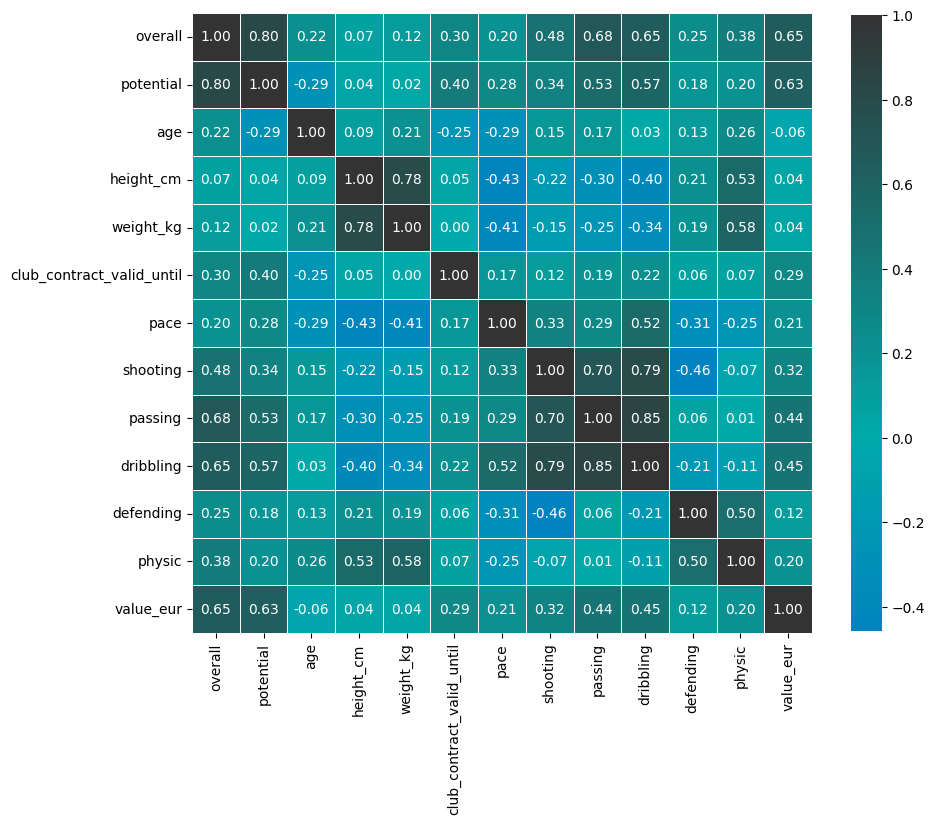

In [ ]:
cmap = sns.color_palette('winter_d', as_cmap=True)
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(players.select_dtypes(exclude=['object']).corr()
            , cmap=cmap
            , vmax=1.0
            , center=0
            , fmt='.2f'
            , square=True
            , linewidths=.5
            , annot=True
            , cbar_kws={"shrink": .8})
plt.show()

### **XGBOOSTING**

The purpose of this section is to train simple XGB regression model and use SHAP values for explaining features importance.

For better model we would require further data cleaning and dealing with outliers within our target column.

In [ ]:
# Separate features and target:
X = players.drop('value_eur', axis=1)
y = players['value_eur']

# Identify column types:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Preprocessing for numerical data:
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Define the model
model = XGBRegressor()

# Create and combine into a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the pipeline
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Squared Error on Test Set: {rmse:.2f}")

Mean Squared Error on Test Set: 1008873.56


 98%|===================| 4671/4775 [00:14<00:00]       

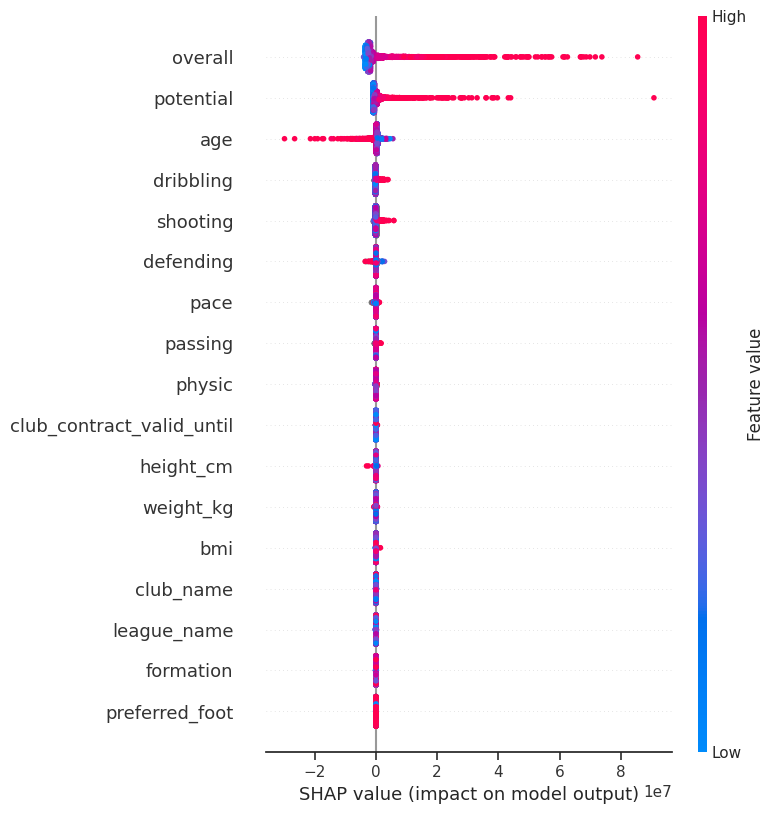

In [ ]:
# Explore SHAP values for XGBRegressor:

# Transform X_train through the preprocessor:
X_train_processed = pipeline.named_steps['preprocessor'].transform(X_train)

# Access the trained XGBoost model:
trained_model = pipeline.named_steps['regressor']

# Create SHAP explainer:
explainer = shap.Explainer(trained_model, X_train_processed)

# Calculate SHAP values:
shap_values = explainer(X_train_processed)

# Plot SHAP summary:
shap.summary_plot(
    shap_values,
    features=X_train_processed,
    feature_names=numerical_cols + categorical_cols
)